# Tweets Sentiment analyses on [sentiment140](https://www.kaggle.com/kazanova/sentiment140) dataset

* [link](https://drive.google.com/file/d/1JVWNB8RIqpCdEbO3S7_VOuQ9Xwnlg2oY/view?usp=sharing) to data file on Google Drive
[link](https://drive.google.com/file/d/1LvKaUEX1cAqPSi3Y5iDU7-44O_zqfB3I/view?usp=sharing) to data zip file on Google Drive
* [link](https://drive.google.com/file/d/1SuLUgRApiR0xr3aHbBYHqOv6m426u9DA/view?usp=sharing) to Linear classifier file on Google Drive
[link](https://drive.google.com/drive/folders/1-UxZylzO3cpxitDWrl2UE7nVVT_E4jt-?usp=sharing) to BERT classifier folder on Google Drive
* [link](https://drive.google.com/file/d/1-0TA272hcn0Cyed3l5mNUYdaFVv7AcSo/view?usp=sharing) to BERT classifier zip file on Google Drive

## use below pattern to unzip folders

In [ ]:
!unzip "/content/drive/My Drive/desktop1.zip" -d "/content/drive/My Drive/"

## Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installation


In [ ]:
import nltk
nltk.download('stopwords')

# Install pickle to save objects's files
! pip install pickle5

# Install sentence-transformer for vectorizing sentences (used for vectorizing tweets for Linear Classifier)
!pip install -U sentence-transformers

# To expand contractions
!pip install contractions

# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

# To use adamW optimizer
!pip install -q tf-models-official

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 133kB 6.7MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218623 sha256=b33e56534dcdee224e3668ae892de18ee4a7304e30974ae8366ed473ade1c68c
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5
     |████████████████████████████████| 71kB 6.0MB/s 
     |████████████████████████████████| 1.8MB 11.2MB/s 
     |████████████████████████████████| 1.2MB 51.5MB/s 
     |████████████████████████████████| 2.9MB 51.0MB/s 
     |████████████████████████████████| 890kB 47.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-cp36-none-any.whl size=103068 sha256=47a131b8cdb9e1d3fad2a1a81f0adc33cbf9b3bc77dcbee3c86831af186aed4e
  Stored in directory: /root/.cache/pip/wheels/3d/33/d1/5703dd56199c09d4a

## Imports

In [ ]:
import pickle5 as pickle

import re
import string
import contractions
from nltk.corpus import stopwords

import pandas as pd
from sklearn.model_selection import train_test_split


from sentence_transformers import SentenceTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import os
import torch


import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer
import math

## Constants 

In [ ]:
# path to where raw datas are in
data_path = 'drive/MyDrive/Colab Notebooks/NLP_final_project/data/'

# path to where processed datas are in
documents_path = 'drive/MyDrive/Colab Notebooks/NLP_final_project/documents/'

csv_file_name = 'training.1600000.processed.noemoticon.csv'
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"



# define below const to use it for BERT model 
# sum of TRAIN_SIZE and VAL_SIZE can't be greater than 1280000
TRAIN_SIZE = 80000
VAL_SIZE = 20000
# TEST_SIZE cant be greater than 32000
TEST_SIZE = 20000

# where linear model is going to be (saved or loaded)
linear_model_path = os.path.join(documents_path, 'linear_model.pickle')
# where bert model is going to be (saved or loaded)
transformer_model_path = os.path.join(documents_path, 'sentiment_bert_classifier')


# while max len is 290, 1599514 data among 1600000 data's length is less or equal to 64
# for training its 1279705 among 1280000 training data
MAX_LEN = 64

# use this model for vectorizing sentences in SentenceTransformer
sentence_vectorizing_model = 'stsb-distilbert-base'

# use this model among all expert bert model presented by tensorflow hub as it's
# recommended for sentiment analysis
bert_model_name = 'experts/bert/wiki_books/sst2'


emoticon_string = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth      
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
    )"""

# The components of the tokenizer:
regex_strings = (
    # Phone numbers:
    r"""
    (?:
      (?:            # (international)
        \+?[01]
        [\-\s.]*
      )?            
      (?:            # (area code)
        [\(]?
        \d{3}
        [\-\s.\)]*
      )?    
      \d{3}          # exchange
      [\-\s.]*   
      \d{4}          # base
    )"""
    ,
    # Emoticons:
    emoticon_string
    ,
    # HTML tags:
    r"""<[^>]+>"""
    ,
    # Twitter username:
    r"""(?:@[\w_]+)"""
    ,
    # Twitter hashtags:
    r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"""
    ,
    # Remaining word types:
    r"""
    (?:[a-z][a-z'\-_]+[a-z])       # Words with apostrophes or dashes.
    |
    (?:[+\-]?\d+[,/.:-]\d+[+\-]?)  # Numbers, including fractions, decimals.
    |
    (?:[\w_]+)                     # Words without apostrophes or dashes.
    |
    (?:\.(?:\s*\.){1,})            # Ellipsis dots. 
    |
    (?:\S)                         # Everything else that isn't whitespace.
    """
)

# This is the core tokenizing regex:
word_re = re.compile(r"""(%s)""" % "|".join(regex_strings), re.VERBOSE | re.I | re.UNICODE)

# The emoticon string gets its own regex so that we can preserve case for them as needed:
emoticon_re = re.compile(regex_strings[1], re.VERBOSE | re.I | re.UNICODE)

# These are for regularizing HTML entities to Unicode:
html_entity_digit_re = re.compile(r"&#\d+;")
html_entity_alpha_re = re.compile(r"&\w+;")
amp = "&amp;"

# use below dictionaries to get chosen pretrained bert model and proper preprocessor for it 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'experts/bert/wiki_books/sst2':   #use this, as its recommended to use this one for sentiment analysis
        'https://tfhub.dev/google/experts/bert/wiki_books/sst2/2',
}

map_model_to_preprocess = {
    
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts/bert/wiki_books/sst2':   #use this, as its recommended to use this one for sentiment analysis
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}


##  text preprocessing

In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not')


def text_preprocessor(text):
    
    # expand contractions
    text = contractions.fix(' '.join(text.split(' ')))
    # remove tagged accounts
    text = ' '.join([token if token[0]!='@'  else '' for token in text.split()])

    # remove URL
    text = re.sub(r'http\S+','',text)

    text = text.replace(amp, " and ")
    words = word_re.findall(text)

    # Possible alter the case, but avoid changing emoticons like :D into :d:
    # if not self.preserve_case:
    # also remove it if it's punctuation (not emoticon)
    words = map((lambda x: x if emoticon_re.search(x) else x.lower().translate(str.maketrans('', '', string.punctuation))), words)
    
    

    # remove stopwords
    words = [word if word not in stop_words else '' for word in words]
    # remove redundant spaces
    text = ' '.join((' '.join(words)).split())
    
    text = text.replace('¡', ' ! ')

    return text

  
# an example of bert_preprocessor
print('----------------     sample of data normalizer     ------------------')

tweet = 'the next school year is the year for exams can\'t think about that­ #school #exams #hate'
print('raw tweet \n\t{}'.format(tweet))
print('text processed tweet: \n\t{}'.format(text_preprocessor(tweet)))

tweet = '@switchfoot http://twitpic.com/2y1zl - Awww, that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D'
print('raw tweet \n\t{}'.format(tweet))
print('text processed tweet: \n\t{}'.format(text_preprocessor(tweet)))
# print(text_preprocessor('i had options i\'d get it removed i\'ve never had acne problems'))

----------------     sample of data normalizer     ------------------
raw tweet 
	the next school year is the year for exams can't think about that­ #school #exams #hate
text processed tweet: 
	next school year year exams not think ­ school exams hate
raw tweet 
	@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
text processed tweet: 
	awww bummer shoulda got david carr third day ;D


## Split data randomely into 2 set of train (80%) and test (20%) 

In [ ]:
# use sklearn train_test_split to randomly split the entire training data into two sets: 
# a train set with 80% of the data and a validation set with 20% of the data

def split_data(csv_data_path):
  csv_data = pd.read_csv(csv_data_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
  # ["target", "ids", "date", "flag", "user", "text"]

  # for each 10 data, assing 8 of them to train, and 2 remained to test
  data = {'text':[], 'label':[]}

  for index in range(csv_data.shape[0]):
    # as its a huge file, also preprocess the text before adding them
    data['text'].append(text_preprocessor(csv_data['text'][index]))
    data['label'].append(csv_data['target'][index])
    
    if index % 100000==0:
      print('* * {:10s}:{:12d}  {:10s}  {:12d}'.format('processed',index,'over',csv_data.shape[0]))

  
  text_train, text_test, label_train, label_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=2020)

  with open(data_path + 'train.pickle', 'wb' ) as train_file:
    pickle.dump({'label':label_train, 'text': text_train}, train_file, protocol= pickle.HIGHEST_PROTOCOL)

  with open(data_path + 'test.pickle', 'wb' ) as test_file:
    pickle.dump({'label':label_test, 'text': text_test}, test_file, protocol= pickle.HIGHEST_PROTOCOL)

split_data(data_path + csv_file_name)

with open(data_path + 'train.pickle', 'rb' ) as train_file:
  train = pickle.load(train_file, encoding = 'utf8')
  # print(len(train['text']))
  label = {0:0, 4:0}
  for l in train['label']:
    label[l] += 1
  print(label)
  # print(len(train['label']))
with open(data_path + 'test.pickle', 'rb' ) as test_file:
  test = pickle.load(test_file, encoding= 'utf8')
  print(test['text'].__class__)
  label = {0:0, 4:0}
  for l in test['label']:
    label[l] += 1
  print(label)


* * processed :           0  over             1600000
* * processed :      100000  over             1600000
* * processed :      200000  over             1600000
* * processed :      300000  over             1600000
* * processed :      400000  over             1600000
* * processed :      500000  over             1600000
* * processed :      600000  over             1600000
* * processed :      700000  over             1600000
* * processed :      800000  over             1600000
* * processed :      900000  over             1600000
* * processed :     1000000  over             1600000
* * processed :     1100000  over             1600000
* * processed :     1200000  over             1600000
* * processed :     1300000  over             1600000
* * processed :     1400000  over             1600000
* * processed :     1500000  over             1600000
{0: 639949, 4: 640051}
<class 'list'>
{0: 160051, 4: 159949}


* represent data

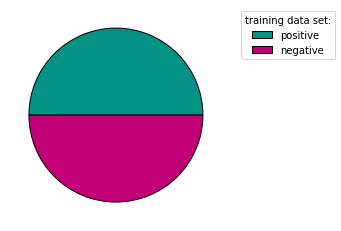

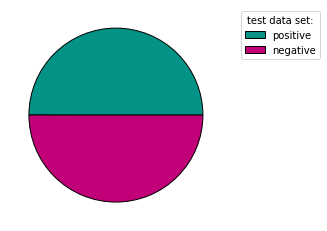

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
train_count = {'positive': 0, 'negative': 0}
test_count = {'positive': 0, 'negative': 0}

with open(data_path + 'train.pickle', 'rb') as train_file:
  train = pickle.load(train_file)
  for label in train['label']:
    if label == 0:
      train_count['negative'] += 1
    else:
      train_count['positive'] += 1
    
with open(data_path + 'test.pickle', 'rb') as test_file:
  test = pickle.load(test_file)
  for label in test['label']:
    if label == 0:
      test_count['negative'] += 1
    else:
      test_count['positive'] += 1
# define pie plots input value

x = np.array(list(train_count.values()))
# a list of colors to be assigned to each condition
my_colors = ['#029386','#c20078']

fig1, ax1 = plt.subplots()
# define the plot
ax1.pie(x, labels=list(train_count.keys()), colors= my_colors, labeldistance= None, wedgeprops = {'edgecolor': 'black'})
# define legend
ax1.legend(title="training data set:",bbox_to_anchor=(1.05, 1), loc='upper left')


fig2, ax2 = plt.subplots()

x = np.array(list(test_count.values()))
# define the plot
ax2.pie(x, labels=list(test_count.keys()), colors= my_colors, labeldistance= None, wedgeprops = {'edgecolor': 'black'})
# define legend
ax2.legend(title="test data set:",bbox_to_anchor=(1.05, 1), loc='upper left')
# show the plot
plt.show()


## Linear Classifier:    SVM model using transformers for vectorizing

### Define Linear Classifier
*   for more details on DistilBERT model used for vectorizing used sentence-transformer represented by [UKPLab](https://github.com/UKPLab/sentence-transformers)
used 'stsb-distilbert-base' model as it's based on a transformer model and it's been one of the best model considering performance and speed based on the  [given results](https://docs.google.com/spreadsheets/d/14QplCdTCDwEmTqrn1LH4yrbKvdogK4oQvYO1K1aPR5M/edit#gid=0)

In [ ]:
class LinearClassifier:
  def __init__(self, train_file_path, test_file_path, model_path= linear_model_path):
    self.train_path = train_file_path
    self.test_path = test_file_path
    # while max len is 290, 1599514 data among 1600000 data's length is less or equal to 64
    # for training its 1279705 among 1280000 training data
    self.MAX_LEN = MAX_LEN
    self.test_chunk_num = 10
    self.train_chunk_num = 40

    # path to where model has been (or going to be) saved
    self.save_model_path = model_path

    # path to vectorized train/test data
    self.train_vectorized_file_path = documents_path + 'vectorized_train_{}.pickle'
    self.test_vectorized_file_path = documents_path + 'vectorized_test_{}.pickle'

  def vectorizer(self, data_dict= None, query= None, train= True):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('current available device is "{}" for vectorizing'.format(device))
    vectorizing_model = SentenceTransformer(sentence_vectorizing_model, device=device)

    if train and query == None:   # vectorizer function has been called for training data
      tweets_vec = {'vec':list(), 'label': list()}
      # first calculate number of tweets with length of less than MAX_LEN
      tweets_count = 0 
      for doc in data_dict['text']:
        if len(text_preprocessor(doc).split()) <= self.MAX_LEN:
          tweets_count += 1
      
      
      # save the vectores in self.train_chunk_num chunks of pickle file as its might not be possible to 
      # feed all of them to model at a same time 
      chunk_size = int(np.floor(tweets_count/self.train_chunk_num))
      chunk_index = 0

      # use index to count number of tweets that have len <= 64
      index = 0
      for doc_id, doc in enumerate(data_dict['text']):
        if len(doc.split()) <= self.MAX_LEN:

          tweets_vec['vec'].append(vectorizing_model.encode([doc])[0])
          tweets_vec['label'].append(data_dict['label'][doc_id])
          index += 1
          
        # if its not last chunck and data for saving next chunk has been generated 
        if index % chunk_size == 0 and chunk_index != self.train_chunk_num - 1:
          # save data with proper name  
          with open (self.train_vectorized_file_path.format(chunk_index), 'wb') as chunk_file:
            pickle.dump({'vec': np.array(tweets_vec['vec'][chunk_index * chunk_size:(chunk_index + 1) * chunk_size]), 
                        'label': np.array(tweets_vec['label'][chunk_index * chunk_size:(chunk_index + 1) * chunk_size])
                        },chunk_file, protocol= pickle.HIGHEST_PROTOCOL)
          chunk_index += 1
          print('* saved train {} chunk'.format(chunk_index))

        if index %10000 ==0 and index != 0:
          print('* vectorizing train tweets * {:10s}:{:12d}  {:10s}  {:12d}'.format('processed',index,'over',tweets_count))
        
      # now save last chunks data
      with open (self.train_vectorized_file_path.format(chunk_index), 'wb') as chunk_file:
        pickle.dump({'vec': np.array(tweets_vec['vec'][chunk_index * chunk_size:]),
                     'label': np.array(tweets_vec['label'][chunk_index * chunk_size:])
                     },chunk_file, protocol= pickle.HIGHEST_PROTOCOL)
      print('* saved train {} chunk'.format(chunk_index))
         
    elif query == None:   # vectorizer function has been called for test data
      
      tweets_vec = {'vec':list(), 'label': list()}

      tweets_count = len(data_dict['text'])      
      chunk_size = int(np.floor(tweets_count/self.test_chunk_num))
      chunk_index = 0

      for doc_id, doc in enumerate(data_dict['text']):
        
        tweets_vec['vec'].append(vectorizing_model.encode([doc])[0])
        tweets_vec['label'].append(data_dict['label'][doc_id])

        # if its not last chunck and data for saving next chunk has been generated 
        if doc_id % chunk_size == 0 and chunk_index != self.test_chunk_num - 1:
          # save data with proper name  
          with open (self.test_vectorized_file_path.format(chunk_index), 'wb') as chunk_file:
            pickle.dump({'vec': np.array(tweets_vec['vec'][chunk_index * chunk_size:(chunk_index + 1) * chunk_size]), 
                        'label': np.array(tweets_vec['label'][chunk_index * chunk_size:(chunk_index + 1) * chunk_size])
                        },chunk_file, protocol= pickle.HIGHEST_PROTOCOL)
          chunk_index += 1
          print('* saved test {} chunk'.format(chunk_index))

        if doc_id %10000 ==0 and doc_id != 0:
          print('* vectorizing test tweets * {:10s}:{:12d}  {:10s}  {:12d}'.format('processed',doc_id,'over',tweets_count))
        
      # now save last chunks data
      with open (self.test_vectorized_file_path.format(chunk_index), 'wb') as chunk_file:
        pickle.dump({'vec': np.array(tweets_vec['vec'][chunk_index * chunk_size:]),
                     'label': np.array(tweets_vec['label'][chunk_index * chunk_size:])
                     },chunk_file, protocol= pickle.HIGHEST_PROTOCOL)
      print('* saved test {} chunk'.format(chunk_index))
      
    else: # if its called for a query  
      return np.array(vectorizing_model.encode([text_preprocessor(query)]))
  
  def define_model(self):
    return SGDClassifier(loss="hinge", penalty="l2")

  def train(self):
    
    try:  # try load training data vectorized file

      # to see which training has the best performans while doing croos over and save that one
      max_accuracy = 0
      # set 32 chunk for training and 8 chunvk for validation
      cross_values = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
                      [ 32, 33, 34, 35, 36, 37, 38, 39,0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
                      [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                      [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                      [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,0, 1, 2, 3, 4, 5, 6, 7]
                      ]
      
      for pattern_id, cross in enumerate(cross_values):
        # define model
        model = self.define_model()

        print('{0:160s}'.format(('-'*50) + '  training {:4d} pattern  '.format(pattern_id + 1)+ ('-'*50)))
        
        for count, chunk in enumerate(cross[:len(cross) - 8]):
          # for each chunk of vectorized training data
          with open(self.train_vectorized_file_path.format(chunk), 'rb') as vectorized_data_file:
            vectorized_chunk = pickle.load(vectorized_data_file) 
            # learning loap
            for i in range(1000):
              model.partial_fit(np.array(vectorized_chunk['vec']),np.array(vectorized_chunk['label']), classes=np.unique(np.array(vectorized_chunk['label'])))
          
          print('* training * {:10s}:{:12d}  {:10s}  {:12d}'.format('processed',count + 1,'over',len(cross)))

        print('{0:160s}'.format(('-'*50) + '  validating {:4d} pattern  '.format(pattern_id + 1)+ ('-'*50)))
        
        # save model accuracy for evaluation data
        accuracy_list = list()
        for count, chunk in enumerate(cross[len(cross) - 8:]):
          with open(self.train_vectorized_file_path.format(chunk), 'rb') as vectorized_data_file:
            vectorized_chunk = pickle.load(vectorized_data_file)
            accuracy_list.append(model.score(np.array(vectorized_chunk['vec']), np.array(vectorized_chunk['label'])))
          print('* validating * {:10s}:{:12d}  {:10s}  {:12d}'.format('processed',count + 1,'over',len(cross)))

        # calculate avg accuracy
        avg_accuracy = sum(accuracy_list)/len(accuracy_list)
        print('{0:160s}'.format(('-'*50) + '  avg accuracy: {:10f}  '.format(avg_accuracy)+ ('-'*50)))

        # update save model
        if avg_accuracy > max_accuracy:
          with open(self.save_model_path, 'wb') as model_file:
            pickle.dump(model, model_file, protocol = pickle.HIGHEST_PROTOCOL)
          # print('-'*40, 'model updated with accuracy: {:10f}'.format(avg_accuracy), '-'*50)
          print('{0:160s}'.format(('-'*50) + ' model updated with accuracy: {:10f} '.format(avg_accuracy)+ ('-'*50)))
          
          max_accuracy = avg_accuracy 

        print('\n','*'*120,'\n')

    except IOError:   # vectorize training data as their files are not exist
      print('-'*10, '\t vectorized training data files do not exist, prepareing them might take a while\t', '-'*10)
      
      # open training data
      with open(self.train_path, 'rb') as train_file:
        train = pickle.load(train_file)
        # vectorize and store them on disk
        self.vectorizer(data_dict= train)

      # now that training vectores are on disk, call the training function again
      self.train()

  def evaluate(self): #evaluate model on test data

    try:  #try to load model
      with open(self.save_model_path, 'rb') as model_file:
        model = pickle.load(model_file)

        try:  # try to load vectorized data

          # store predicted labels
          y_pred = list()
          # store given labels
          y_true = list()

          for chunk in range(self.test_chunk_num): 
            # first load vectorized data
            with open(documents_path + 'vectorized_test_{}.pickle'.format(chunk), 'rb') as vectorized_test_file:
              vector_dict = pickle.load(vectorized_test_file)
              # give it's tweets as loaded classifier model predict function to
              #  get predicted labels as it's output and store them properly
              y_pred += list(model.predict(vector_dict['vec']))
              # also store true value for labels
              y_true += list(vector_dict['label'])
          
          # use y_pred and y_true values to evalute classifier model
          report = classification_report(y_true, y_pred)
          confusion_mat = confusion_matrix(y_true, y_pred)
          # return evaluation metrics
          return report, confusion_mat
              
        except: # vectorized data are not exist
          print('-'*10, '\t vectorized test data files do not exist, preparing them might take a while\t', '-'*10)
          # load test data and fed it to self.vectorizer with train= false to save
          # vectorized chunk of test data to use it to evalute the classifier
          with open(self.test_path, 'rb') as test_file:
            test_data = pickle.load(test_file)
            # vectorize an save vectores for test data 
            # (as they are too many to store all of them on memory)
            self.vectorizer(data_dict= test_data, train= False)

            # now that all test data has been vectorized and stored on the disk
            # recall evaluate function to evaluate model using them
            self.evaluate()
   
    except IOError:   # model file does notexist
      print('-'*10, '\t Classier model file does not exist, preparing it might take a while\t', '-'*10)
      self.train()
      self.evaluate()    
      
  def query(self, query_text): # classify single sentence
    # first vectorize query (it'll proprocess text in vectorize function)
    query_vector = self.vectorizer(query= query_text, train= False)
    # load the classifier model into memory
    y_predict = 0
    try:
      with open(self.save_model_path, 'rb') as model_file:
        model = pickle.load(model_file)
        # now get model prediction for the tweets vector
        y_predict = model.predict(query_vector)
    except:
      print('-'*10, '\t Classier model file does not exist, preparing it might take a while\t', '-'*10)
      self.train()
      with open(self.save_model_path, 'rb') as model_file:
        model = pickle.load(model_file)
        # now get model prediction for the tweets vector
        y_predict = model.predict(query_vector)
    # return the result
    if y_predict == 0:
      return 'negative'
    else:
        return 'positive'



current available device is "cuda" for vectorizing


100%|██████████| 245M/245M [00:14<00:00, 16.3MB/s]


### Train and Evaluate SVM model

* Create an object form LinearClassifier

In [ ]:
train_data_path = os.path.join(data_path, 'train.pickle')
test_data_path = os.path.join(data_path, 'test.pickle')

svm_model = LinearClassifier(train_data_path, test_data_path)

* Train the classifier

In [ ]:
svm_model.train()

* Evaluate the classifier

In [ ]:
report, matrix = svm_model.evaluate()
# print evaluations metrics
print(report,'\n', matrix)


              precision    recall  f1-score   support

           0       0.74      0.70      0.72    160051
           4       0.72      0.76      0.74    159949

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000
 
 [[112393  47658]
 [ 39063 120886]]


Give a single tweet to classifier to classify it

In [ ]:
tweet = 'safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!'
# result = f'input: {tweet:<30} : class: {svm_model.query(tweet))}'
print('{0:<100s}{1:10s}{2:>10s}'.format(tweet,'',svm_model.query(tweet)))

tweet = 'the next school year is the year for exams.ð¯ can\'t think about that ð­ #school #exams #hate'
# result = f'input: {tweet:<30} : class: {svm_model.query(tweet))}'

print('{0:<100s}{1:10s}{2:>10s}'.format(tweet,'',svm_model.query(tweet)))

safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!                                               posetive
the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate                negative


## Transformer:   Classify with BERT

### Define DataSequence and BertClassifier classes

* Define an Sequence object, use it to convert data to batches

In [ ]:
import numpy as np
import math
class DataSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        return (np.array(batch_x),
                np.array(batch_y))
  

* BertClassifier class, which use one of [Bert Expert](https://tfhub.dev/google/collections/experts/bert/1)  models which is recommended for sentiment tasks ([wiki_books/sst2](https://tfhub.dev/google/experts/bert/wiki_books/sst2/2))
* for crossentropy as using from_logits=True may be more numerically stable, define it in this form

In [ ]:
import math

from sklearn.metrics import classification_report, confusion_matrix


class BertClassifier():
  def __init__(self, train_file_path, test_file_path, saved_model_path = transformer_model_path):
    self.train_file_path = train_file_path
    self.test_file_path = test_file_path

    self.saved_model_path = saved_model_path
    # assign their value based on const value defined in constants cell
    self.train_size = TRAIN_SIZE
    self.val_size = VAL_SIZE
    self.test_size = TEST_SIZE

    self.tfhub_handle_encoder = map_name_to_handle[bert_model_name]
    self.tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]
    
    self.model = None
  
  def build_classifier_model(self):
    # string of inputs
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # define chosen BERT preprocessor 
    preprocessing_layer = hub.KerasLayer(self.tfhub_handle_preprocess, name='preprocessing')
    # get the output required for next layer by passing text_input 
    encoder_inputs = preprocessing_layer(text_input)
    # now pass it to chosen encoder(which was recomended for sentiment analyses)
    encoder = hub.KerasLayer(self.tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    # get the output of the BERT_encoder layer
    outputs = encoder(encoder_inputs)
    
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

  def train(self, batch_size= 32, epochs= 5):
    with open(self.train_file_path, 'rb') as train_file:
      data = pickle.load(train_file)
      train_ds = DataSequence(data['text'][:self.train_size], [0 if label == 0 else 1 for label in data['label'][:self.train_size]], batch_size)
      val_ds = DataSequence(data['text'][self.train_size:self.train_size + self.val_size], [0 if label == 0 else 1 for label in data['label'][self.train_size:self.train_size + self.val_size]], batch_size)

      loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
      metrics = tf.metrics.BinaryAccuracy()

      steps_per_epoch = train_ds.__len__()
      num_train_steps = steps_per_epoch * epochs
      num_warmup_steps = int(0.1*num_train_steps)

      init_lr = 3e-5
      optimizer = optimization.create_optimizer(init_lr=init_lr,
                                                num_train_steps=num_train_steps,
                                                num_warmup_steps=num_warmup_steps,
                                                optimizer_type='adamw')

      self.model = self.build_classifier_model()

      self.model.compile(optimizer= optimizer,
                              loss= loss,
                              metrics= metrics)

      self.model.fit(x= train_ds, epochs= epochs, validation_data= val_ds)

      self.model.save(self.saved_model_path, include_optimizer=False)

  def evaluate(self):
    try: 
      if self.model is None:
        self.model = tf.saved_model.load(self.saved_model_path)
    except IOError:
      print('-'*10, '\t Classier model files do not exist, preparing them might take a while\t', '-'*10)
      self.train()
      self.model = tf.saved_model.load(self.saved_model_path)

    y_true = list()
    loaded_y_pred = list()
    with open(self.test_file_path, 'rb') as train_file:
      test = pickle.load(train_file)
      y_true = test['label'][:self.test_size]

      prob_list = list()
      for text in test['text'][:self.test_size]:
        prob_list += list(tf.sigmoid(self.model(tf.constant([text]))).numpy()[0])

      y_pred = [4 if p >=0.5 else 0 for p in prob_list]

    report = classification_report(np.array(y_true), np.array(y_pred))
    confusion_mat = confusion_matrix(np.array(y_true), np.array(y_pred))

    return report, confusion_mat

  def query(self, tweet):
    prob = 0.0
    try: 
      # load model
      if self.model is None:
        self.model = tf.saved_model.load(self.saved_model_path)
      prob= list(tf.sigmoid(self.model(tf.constant([text_preprocessor(tweet)]))).numpy()[0])[0]

    except IOError:
      print('-'*10, '\t Classier model files do not exist, preparing them might take a while\t', '-'*10)
      self.train()
      # load model
      if self.model is None:
        self.model = tf.saved_model.load(self.saved_model_path)
      prob= list(tf.sigmoid(self.model(tf.constant([text_preprocessor(tweet)]))).numpy()[0])[0]

    if prob < 0.5:
      return 'negative\t{:.4f}'.format(prob)
    else:
      return 'positive\t{:.4f}'.format(prob)



### Train and Evaluate BERT model

* create an object from BertClassifier class

In [ ]:
train = os.path.join(data_path, 'train.pickle')
test = os.path.join(data_path, 'test.pickle')
bert_model = BertClassifier(train, test)

* represent model layers

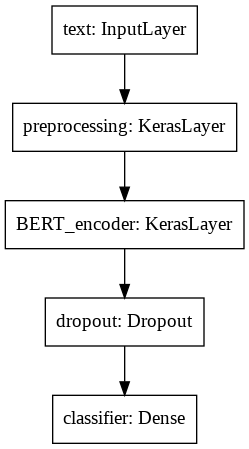

In [ ]:
tf.keras.utils.plot_model(bert_model.model)

* train bert_model

In [ ]:
bert_model.train()

Epoch 1/5
2500/2500 [==============================] - 2493s 991ms/step - loss: 0.5538 - binary_accuracy: 0.7056 - val_loss: 0.4665 - val_binary_accuracy: 0.7704
Epoch 2/5
2500/2500 [==============================] - 2534s 1s/step - loss: 0.4422 - binary_accuracy: 0.7869 - val_loss: 0.5041 - val_binary_accuracy: 0.7648
Epoch 3/5
2500/2500 [==============================] - 2546s 1s/step - loss: 0.3700 - binary_accuracy: 0.8310 - val_loss: 0.5085 - val_binary_accuracy: 0.7753
Epoch 4/5
2500/2500 [==============================] - 2544s 1s/step - loss: 0.3027 - binary_accuracy: 0.8691 - val_loss: 0.5959 - val_binary_accuracy: 0.7790
Epoch 5/5
2500/2500 [==============================] - 2542s 1s/step - loss: 0.2497 - binary_accuracy: 0.8958 - val_loss: 0.6663 - val_binary_accuracy: 0.7749


* evaluate model

In [ ]:
report, matrix = bert_model.evaluate()
print(report, '\n', matrix)

              precision    recall  f1-score   support

           0       0.78      0.81      0.79     10217
           4       0.79      0.76      0.77      9783

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000
 
 [[8230 1987]
 [2353 7430]]


* get result of bert_model on query

In [ ]:
tweet = 'safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!'
# result = f'input: {tweet:<30} : class: {svm_model.query(tweet))}'
print('{0:<100s}{1:10s}{2:>10s}'.format(tweet,'',bert_model.query(tweet)))

tweet = 'the next school year is the year for can\'t think about that #school #exams #hate'
# result = f'input: {tweet:<30} : class: {svm_model.query(tweet))}'

print('{0:<100s}{1:10s}{2:>10s}'.format(tweet,'',bert_model.query(tweet)))

safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!                                             positive	0.8998
the next school year is the year for can't think about that #school #exams #hate                              negative	0.1209


# All Together

* Define both Linear and Bert Classifier sample

In [ ]:
train_data_path = os.path.join(data_path, 'train.pickle')
test_data_path = os.path.join(data_path, 'test.pickle')

linear_classifier_sample = LinearClassifier(train_data_path, test_data_path)
bert_classifier_sample = BertClassifier(train_data_path, test_data_path)

### See performanse on some raw tweets

In [ ]:
sample_raw_tweets= ['The Life is cool. But not for Me. ',
 "I'm missing you babe..  but as long as your alive I'm happy.. Yawwwnn.. I'm tired my love imma try to sleep hopefully you had a headstart",
 'Crazy wind today = no birding  http://ff.im/1XTTi', 'Is not going to sleep tonite. ', 
 '@labelsnotlove   my home town. My mammy called all depressd.  Pls explain y a parent let their 8yr old child walk alone? Hello? Its 2009!',
  "@jokerrrr It stillllll hasn't arrived ",
 "@a5hleyf i'm spending time with my grandma early tomorrow and i can't leave skittles by herself. ",
 '@ScoutBuck tons no hay Troll? ahhhh ',  
 '@alejandralei i dont think i can cause its my cousins birthday party ',
 'have watched that considering today. yaknow. shawnna tomomorrow;i need my bestfriend ', '@shandasaurus  I see.',
 '@phlaimeaux where are you? ', '@thousand_miles no ',
 "@hannahsix cream for his eye and he may have herpes - not ocular herpes, but a different strain.    He's doing okay though.",
 "It's going to be a long year for A's fans. ", '@AmberPacific i know i dont know why i said that ',
 'Almost through with my Italian homework!  Weeeeee.... now if I only understood what I was doing.  ',
 "@t_wolfe  i miss u too. i'm totally comin back tho! Lastnight was sooooooo much fun!",
 'Argh, got up early for Girls Aloud on Freshly Squeezed and it was just the video ',
 '@_saffron  Why not? :[', 'At mobilityvic.org launch.  No grog  nice video from PWC though',
 '@ourcitylight that was so sudden!! ', 'bedtime. wake up call at 7am ', "@almostcool i'm off now ", 
 '@ekim1406 hehehe too bad they were separated ', '@DanielCalderonL yeaah I hate that! ',
 "I'm going to love this season of the hills... I can tell!  Spartans sucked.    Goodnight!!",
 "@NeYawn Yeah! Interview... Don't know even when it is... ",
 '@garretjiroux do u write back on twitter? i miss ya garee...  x', "@zaibatsu ME...I'm up.  ",
 "Almost finished with new moon.... If I didn't have to work tomorrow I would totally finish it tonight! Geez... ",
 "@pilvlp My luck I'd probably get stopped by a cop or something stupid!  ", 
 '@SukottoXD I saw ice in the rain today. Not quite snow, but frozen water, nonetheless. ',
 'has realized that twitter is getting more attention from her mama then she is....hahaha  LAME!',
 'whoa im super hungry  Life cereal w/granola &amp; raspberries is calling my name',
 "Really let down by gossip girl...it's all I have to make my Mondays good and all they give are reruns... ",
 "They don't get hyphy on the east coast  ...even to E40", 'No rain please ',
 'No TravoRadio this morning. BlipFM is down. ', '@PrinceDavey aww no invite??  lol jk. coolness for the day off!',
 "Note to you all: don't go to the choclate bar @ schiphol!! it is passengers only ", 'on the coach  gonna be fun!'
 ]

first = True
for tweet in sample_raw_tweets:
    linear_pred = linear_classifier_sample.query(tweet)
    bert_pred = bert_classifier_sample.query(tweet)
    if first:
      print('{0:<140s}  |  {1:>10s}  |  {2:>10s}\t'.format('raw tweets text', 'Linear pred', 'Bert pred'))
      print('-' * 180)

      first = False
    print('{0:<140s}  |  {1:>10s}  |  {2:>10s}\t'.format(tweet, linear_pred, bert_pred))
    print('-' * 180)



raw tweets text                                                                                                                               |  Linear pred  |   Bert pred	
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
The Life is cool. But not for Me.                                                                                                             |    negative  |  negative	0.4184	
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
I'm missing you babe..  but as long as your alive I'm happy.. Yawwwnn.. I'm tired my love imma try to sleep hopefully you had a headstart     |    negative  |  negative	0.4849	
---------------------------------------------------------------------------------------------------------------

### Get a tweet text and  get result of both classifier

In [ ]:
tweet = input('Enter a Tweet text\t')
linear_pred = linear_classifier_sample.query(tweet)
bert_pred = bert_classifier_sample.query(tweet)
print('-' * 41)
print('|\t{0:>10s}  |  {1:>10s}\t|'.format('Bert pred', bert_pred))
print('-' * 41)
'it was not that bad'
print('|\t{0:>10s}  |  {1:>10s}\t|'.format('Linear pred', linear_pred))
print('-' * 41)

Enter a Tweet text	'it was not that bad'
-----------------------------------------
|	 Bert pred  |  positive	0.9393	|
-----------------------------------------
|	Linear pred  |    negative	|
-----------------------------------------
